In [62]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=100)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles3"
TILE_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img

SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
gene_list=["SLITRK6", "PGM5", "LINC00645", 
           "TTLL12", "COX6C", "CPB1",
           "KRT5", "MALAT1"]
gene = gene_list[0]
print(gene)

SLITRK6


In [5]:
for adata in [
    Sample1,
    Sample2,
]:

    st.pp.filter_genes(adata,min_cells=3)
    st.pp.normalize_total(adata)
    st.pp.log1p(adata)

    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    st.pp.tiling(adata, TILE_PATH_, crop_size=299)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


In [6]:
training_index = Sample1.obs.sample(frac=0.7, random_state=1).index
training_dataset = Sample1[training_index,].copy()

valid_index = Sample1.obs.index.isin(training_index)
valid_dataset = Sample1[~valid_index,].copy()

test_dataset = Sample2.copy()

train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=training_dataset, 
                          genes=[gene], aug=True),
            output_types=(tf.float32, tf.float32), 
            output_shapes=([299,299,3], [1])
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=valid_dataset, 
                          genes=[gene]), 
            output_types=(tf.float32, tf.float32), 
            output_shapes=([299,299,3], [1])
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset, 
                          genes=[gene]), 
            output_types=(tf.float32, tf.float32), 
            output_shapes=([299,299,3], [1])
)
test_gen_ = test_gen.batch(1)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tf.compat.v1.enable_eager_execution()
tfd = tfp.distributions
tfb = tfp.bijectors
import six
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.tf_utils import is_tensor_or_variable

def ZINB_layer(out): 
    n = tf.squeeze(tf.math.softplus(out[:,0:1]))

    p = tf.squeeze(tf.math.sigmoid(out[:,1:2]))

    s = tf.math.sigmoid(out[:,2:3])

    probs = tf.concat([1-s, s], axis=1)
    
    mix = tfd.Mixture(
          cat=tfd.Categorical(probs=probs),
          components=[
          tfd.Deterministic(loc=tf.zeros_like(n)),
          tfd.NegativeBinomial(total_count=n, probs=p),
        ])
    return mix


def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))


class MeanMetricWrapper(tf.keras.metrics.Mean):
    def __init__(self, fn, name=None, dtype=None, **kwargs):
        super(MeanMetricWrapper, self).__init__(name=name, dtype=dtype)
        self._fn = fn
        self._fn_kwargs = kwargs
    def update_state(self, y_true, y_pred, sample_weight=None):
        matches = self._fn(y_true, y_pred, **self._fn_kwargs)
        return super(MeanMetricWrapper, self).update_state(
                     matches, sample_weight=sample_weight)
    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = K.eval(v) if is_tensor_or_variable(v) else v
        base_config = super(MeanMetricWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def vgg16_ZINB(tile_shape):
    tile_input = Input(shape=tile_shape, name = "tile_input")
    VGG16_base = VGG16(input_tensor=tile_input, weights='imagenet', include_top=False)
    for layer in VGG16_base.layers:
        layer.trainable = False
    
    cnn = VGG16_base.output
    cnn = GlobalAveragePooling2D()(cnn)
    cnn = Dropout(0.5)(cnn)
    cnn = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
                activity_regularizer=tf.keras.regularizers.l2(0.01))(cnn)
    # cnn = Dense(256, activation='relu')(cnn)
    
    outputs = Dense(3)(cnn)

#     p_y_zinb = tfp.layers.DistributionLambda(zero_inf)(outputs)
    p_y_zinb = tfp.layers.DistributionLambda(ZINB_layer)(outputs)

    model = Model(inputs=tile_input, outputs=p_y_zinb)

#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss=NLL,
                  optimizer=optimizer,
                  metrics=[MeanMetricWrapper(NLL, name="nll")])    
    return model

In [96]:
def resnet_ZINB(tile_shape):
    tile_input = Input(shape=tile_shape, name = "tile_input")
    resnet_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
    stage_5_start = resnet_base.get_layer("conv5_block1_1_conv")
    for i in range(resnet_base.layers.index(stage_5_start)):
        resnet_base.layers[i].trainable = False
    
    cnn = resnet_base.output
    cnn = GlobalAveragePooling2D()(cnn)
    cnn = Dropout(0.5)(cnn)
    cnn = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
                activity_regularizer=tf.keras.regularizers.l2(0.01))(cnn)
    # cnn = Dense(256, activation='relu')(cnn)
    
    outputs = Dense(3)(cnn)

#     p_y_zinb = tfp.layers.DistributionLambda(zero_inf)(outputs)
    p_y_zinb = tfp.layers.DistributionLambda(ZINB_layer)(outputs)

    model = Model(inputs=tile_input, outputs=p_y_zinb)

#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss=NLL,
                  optimizer=optimizer,
                  metrics=[MeanMetricWrapper(NLL, name="nll")])    
    return model

In [97]:
model = resnet_ZINB((299, 299, 3))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_nll', patience=20,
                                            restore_best_weights=False)

In [98]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(3)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            rotate=(-45, 45), # rotate by -45 to +45 degrees
        )),

        iaa.SomeOf((0, 1),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), 
                ]),

                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), 
                iaa.AddToHueAndSaturation((-20, 20)), 
                iaa.Grayscale(alpha=(0.0, 1.0)),
#               
            ],
            random_order=True
        )
    ],
    random_order=True
)

def tf_seq(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(lambda x:seq_aug(image=x), [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

In [99]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
import numpy as np
#from imgaug import seq_aug

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, adata, dim=(299, 299), n_channels=3, genes=None, aug=False):
        'Initialization'
        self.dim = dim
        self.adata = adata
        self.n_channels = n_channels
        self.genes = genes
        self.num_genes = len(genes)
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.adata.n_obs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        obs_temp = self.adata.obs_names[index]

        # Generate data
        X_img = self._load_img(obs_temp)
        y = self._load_label(obs_temp)

        return X_img, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.adata.n_obs)


    def _load_img(self, obs):
        img_path = self.adata.obs.loc[obs, 'tile_path']
        X_img = image.load_img(img_path, target_size=self.dim)
        X_img = image.img_to_array(X_img).astype('uint8')
#         X_img = np.expand_dims(X_img, axis=0)
#         n_rotate = np.random.randint(0, 4)
#         X_img = np.rot90(X_img, k=n_rotate, axes=(1, 2))
        if self.aug:
            X_img = seq_aug(image=X_img)
        X_img = preprocess_resnet(X_img)
        return X_img

    def _load_label(self, obs):
        return self.adata.to_df().loc[obs, self.genes]

    def get_classes(self):
        return self.adata.to_df().loc[:,self.genes]

In [ ]:
train_history2 = model2.fit(train_gen_,
                          epochs=10,
                          validation_data=valid_gen_,
                          callbacks=[callback]
                          )

In [ ]:
'''import h5py
from keras.models import load_model 
import tensorflow as tf
tf.saved_model.save(model,'LIME_reg1')
model1 = tf.keras.models.load_model("LIME_reg1")'''

# LIME

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


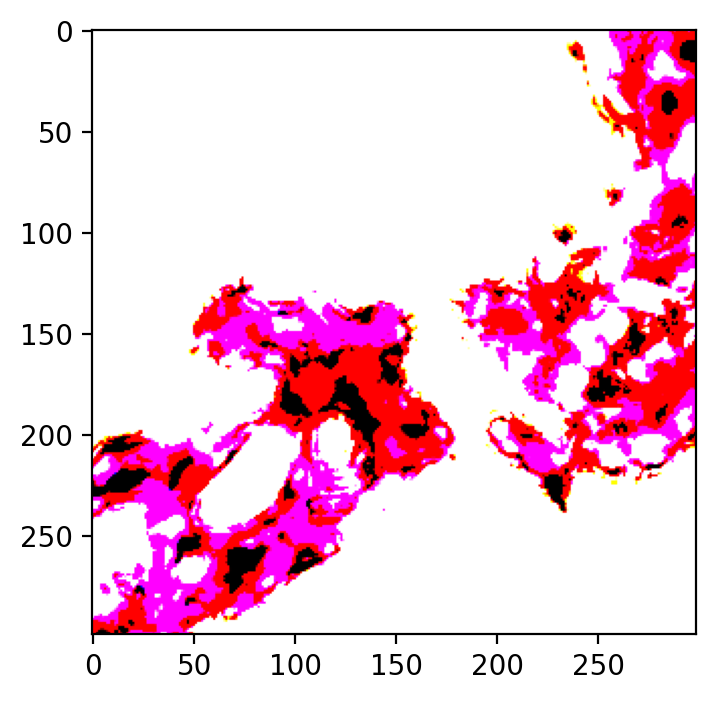

In [65]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)
import os
from keras.applications.imagenet_utils import decode_predictions
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles3/block1','4176-20901-299.jpeg')])
plt.imshow(images[0]/2 + 0.5)
preds = model.predict(images)

In [101]:
%%time
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1, model_regressor=model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/1 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# SHAP

In [66]:
import keras
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap

file = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles3/block1/4176-20901-299.jpeg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)


skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


In [67]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [68]:
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

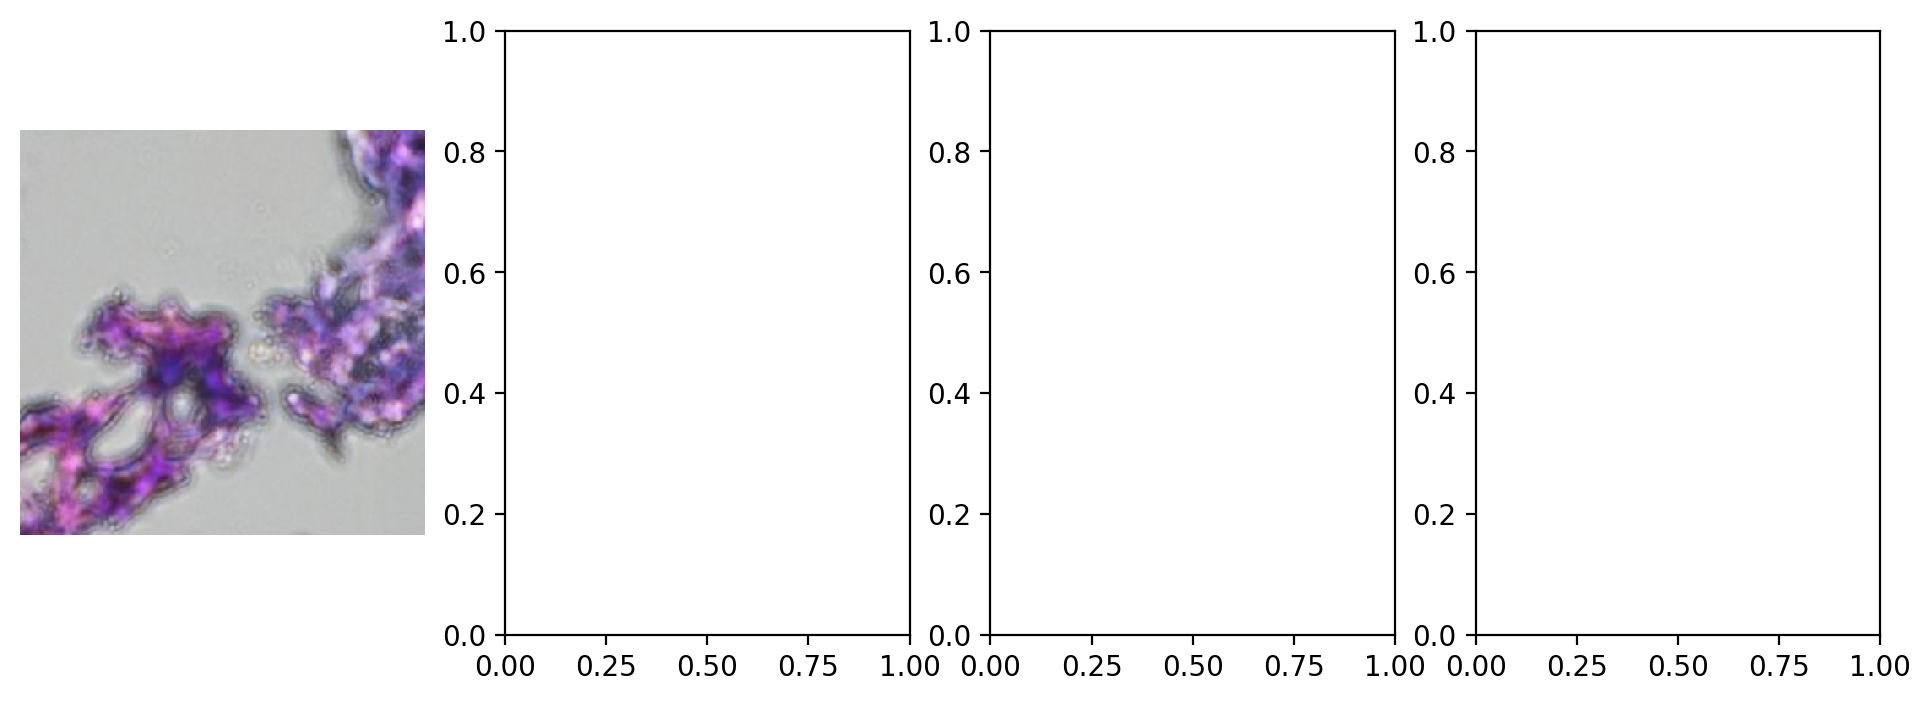

In [71]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()

In [93]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tile_input (InputLayer)         [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           tile_input[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________